In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from sys import stdout
from skimage.morphology import binary_opening, disk
import torch
import pandas as pd
from tqdm import tqdm
from models.unet.src.utils.dataset import AirbusUnetDataset
from utils.get_model import get_model
from utils.helpers import PATHS, multi_rle_encode
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools


model_name = 'unet'
out_path = '/zhome/82/4/212615/deep-learning-project/job_out/unet/23247397'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_img_test = os.listdir(PATHS['test'])


########## Load model ##########
model_path = os.path.join(out_path, 'model.pt')

print(f"RUNNING ON {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Load model
model = get_model(model_name)
state = torch.load(str(model_path), map_location=device, weights_only=False)
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)
model = model.to(device)
model.eval()



########## Make s1bmission ##########

##### DATA LOADER #####
test_df = pd.DataFrame({ 'ImageId': list_img_test, 'EncodedPixels': None })
ds = AirbusUnetDataset(test_df, mode='test')
loader = torch.utils.data.DataLoader(dataset=ds, shuffle=False, batch_size=1, num_workers=0)

RUNNING ON CPU


In [2]:
def normalize(image, permute=True):
    image = (image - image.min()) / (image.max() - image.min())
    if permute:
        image = image.permute(1, 2, 0).numpy()
    return image

In [3]:
n = 10
loader_iter = iter(loader)
images, images_names = next(itertools.islice(loader_iter, n, n+1))

# for batch_idx, (images, images_names) in enumerate(iter(loader)):
#     fig, axes = plt.subplots(1, 2, figsize=(5, 5))
#     for i, image in enumerate(images):
#         axes[i].imshow(normalize(image))
#     fig.suptitle(f'Batch {batch_idx}', fontsize=16)

In [4]:
# Evaluate test images
outputs = model(images.to(device))

[{'ImageId': '002a943bf.jpg',
  'EncodedPixels': '492110 6 492872 13 493637 19 494404 23 495169 27 495935 30 496702 32 497469 34 498236 36 499003 38 499771 38 500538 40 501305 42 502073 42 502840 43 503608 44 504375 46 505142 47 505910 47 506677 48 507445 48 508213 49 508980 50 509747 51 510515 51 511283 51 512050 52 512818 51 513585 52 514353 52 515121 52 515888 53 516656 52 517423 53 518191 53 518959 52 519727 52 520494 52 521262 52 522030 51 522797 52 523565 52 524333 52 525101 51 525869 51 526636 51 527404 51 528171 51 528939 51 529706 51 530474 50 531241 51 532009 50 532777 50 533544 50 534311 51 535079 50 535847 50 536614 51 537382 50 538149 51 538917 51 539685 50 540453 50 541220 50 541988 50 542755 50 543523 50 544291 50 545058 50 545826 50 546593 51 547361 51 548129 51 548897 50 549664 51 550432 51 551200 50 551967 51 552735 51 553503 50 554270 51 555038 51 555806 51 556573 51 557341 51 558109 50 558876 51 559644 50 560412 49 561179 50 561947 49 562714 50 563482 50 564249 50 5

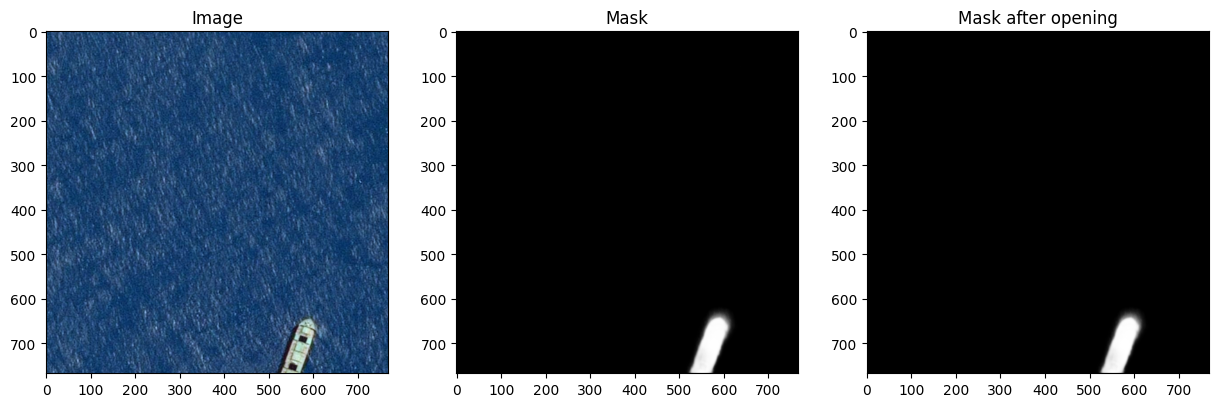

In [5]:

out_pred_rows = []
for i, (image, image_name) in enumerate(zip(images, images_names)):

    mask = F.sigmoid(outputs[i,0]).data.detach().cpu().numpy()
    cur_seg = binary_opening(mask>0.5, disk(2))

    ############################################################
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot data on each subplot
    axes[0].imshow(normalize(image))
    axes[0].set_title('Image')

    axes[1].imshow(normalize(mask, False), cmap="gray")
    axes[1].set_title('Mask')

    axes[2].imshow(normalize(mask, False), cmap="gray")
    axes[2].set_title('Mask after opening')
    ############################################################

    cur_rles = multi_rle_encode(cur_seg)
    
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': c_rle }]
    else:
        out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': None}]

out_pred_rows